## Week 14 Lecture 1

We will get more practice with logistic regression by studying a dataset about breast cancer. The records contain information about biopsied tumors in clinical cases at University of Wisconsin. For each patient, physicians inspected a sample of cells with fine needle aspiration. Among the different features of the tumors, physicians recorded the diagnosis of 

- benign 
- malignant

Here logistic regression can help to predict benign or malignant tumor from the other features like shape and size of cells. 

In [24]:
# import packages 

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, LogisticRegression
from scipy.optimize import minimize

from helper_functions import *

# change settings

pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 8)

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['font.size'] = 16

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# import for configuration

from IPython.display import Image

The dataset consists of 699 rows and 11 columns.  

- `id` : Identifier of Biopsy
- `thick` : Clump Thickness
- `size_unif` : Uniformity of Cell Size
- `shape_unif` : Uniformity of Cell Shape
- `marg` : Marginal Adhesion
- `cell_size` : Single Epithelial Cell Size
- `bare` : Bare Nuclei
- `chrom` : Bland Chromatin
- `normal` : Normal Nucleoli
- `mit` : Mitoses
- `class` : Malignant or Benign 

Note that `class` is a qualitative variable consisting of 

- 0 for benign
- 1 for malignant 

Note that `thick`,`size_unif`,`shape_unif`,`marg`,`cell_size`,`bare`,`chrom`,`normal`, and `mit` are quantitative variables with values ranging from 0 through 10. We drop 16 rows containing missing data. 

In [2]:
# load dataset 
biopsy = pd.read_csv("breast_cancer_biopsies.csv")
biopsy

,id,thick,size_unif,shape_unif,...,chrom,normal,mit,class
0,1000025,5,1,1,...,3,1,1,0
1,1002945,5,4,4,...,3,2,1,0
2,1015425,3,1,1,...,3,1,1,0
3,1016277,6,8,8,...,3,7,1,0
4,1017023,4,1,1,...,3,1,1,0
...,...,...,...,...,...,...,...,...,...
678,776715,3,1,1,...,1,1,1,0
679,841769,2,1,1,...,1,1,1,0
680,888820,5,10,10,...,8,10,2,1
681,897471,4,8,6,...,10,6,1,1


#### Plotting the Data

The objective is to identify benign or malignant classes. After loading the data, we can create a scatter-plot labeling the classes with different colors. 

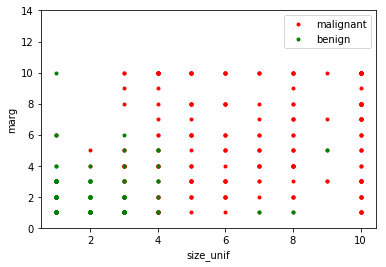

In [3]:
# Get records
malignant_records = biopsy[biopsy["class"] == 1] 
benign_records =  biopsy[biopsy["class"] == 0]

# Create the scatter plot
plt.plot(malignant_records["size_unif"],malignant_records["marg"],'r.', label = "malignant")
plt.plot(benign_records["size_unif"],benign_records["marg"],'g.', label = "benign")
plt.xlabel("size_unif")
plt.ylabel("marg")
plt.ylim(0,14)
plt.legend();

We will focus on two of the features 

- Uniformity of Cell Size 
- Marginal Adhesion

Remember that we abbreviate these featues as `size_unif` and `marg`. Note that we have some over-plotting. We can jitter the point to display points with overlapping coordinates.

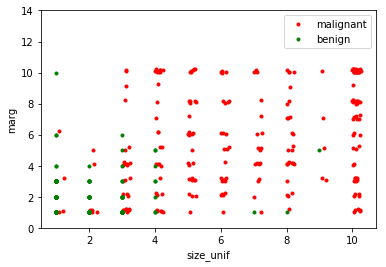

In [4]:
data = biopsy
amount_jitter = 0.25

plot_scatter_plot(data, amount_jitter)

Despite jittering the points, the chart is not informative because we cannot see the relative frequency of malign and benign points. Instead we can use a histogram. Since we are working with two variables, we would need to have 3-dimensions for the chart. However, we can use the size of the points to denote the heights of the rectangles. 

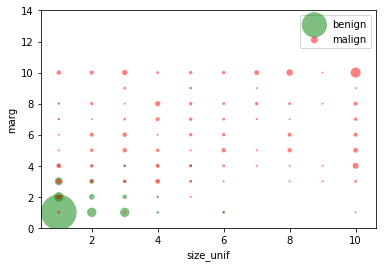

In [5]:
data = biopsy 
explanatory_variables = ["size_unif", "marg"] 
response_variables = "class"

plot_histogram(data, explanatory_variables, response_variables)

Here are some ideas for classification that you may have already thought of.  We can see that the benign samples are located in the lower left.  So, one simple classification rule is to define the region with a line.  We plot the region for one possible line with the following code.

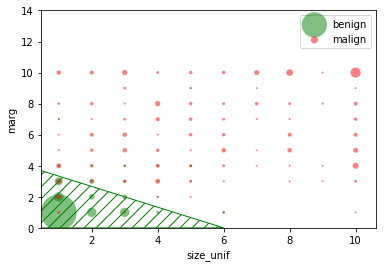

In [6]:
data = biopsy 
explanatory_variables = ["size_unif", "marg"] 
response_variables = "class"

plot_histogram(data, explanatory_variables, response_variables)
add_patch(plt.gca(), [[0,0],[0,4],[6,0]])

Here is an alternate classification rule based on two linear constraints.

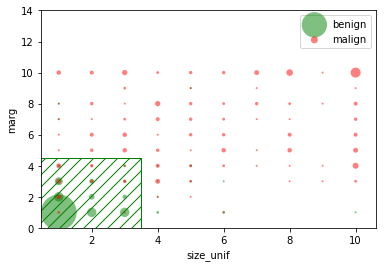

In [7]:
data = biopsy 
explanatory_variables = ["size_unif", "marg"] 
response_variables = "class"

plot_histogram(data, explanatory_variables, response_variables)
add_patch(plt.gca(), [[0,0],[3.5,0],[3.5,4.5],[0,4.5]])

#### Regression

Instead of guessing an approach to classifying the biopsies, we should use a model for prediction. 

##### Linear Regression 

Before we learned about logisitic regression for qualitative response variables, we studied linear regression for quantitative response variables. If we pretend the `class` column consists of quantitative variables 0 and 1, then can we make guesses with linear regression?

In [8]:
linear_model = LinearRegression()
linear_model.fit(data[explanatory_variables],data[response_variables])

intercept = linear_model.intercept_
slopes = linear_model.coef_

print('Intercept =', intercept)
print('Slopes =', slopes)

Intercept = -0.08420066620061473
Slopes = [0.10007944 0.04197521]


Here we have a linear regression model with three parameters 

$$\hat{y} = w_0 + w_1 \text{size_unif} + w_2 \text{marg}$$

We can use the model for classification by guessing 

$$\begin{cases} 1 & \text{if } \hat{y} \geq 0.5 \\ 0 & \text{if } \hat{y} < 0.5  \end{cases}$$

So the model will predict 0 or 1 for each combination of the features `size_unif` and `marg`. We can visualize the separation into 0 and 1 by plotting the line

$$\frac{1}{2} = w_0 + w_1 \cdot \text{size_unif} + w_2 \cdot \text{marg}$$

The line will break the chart into two regions corresponding to guesses of 0 and 1. 

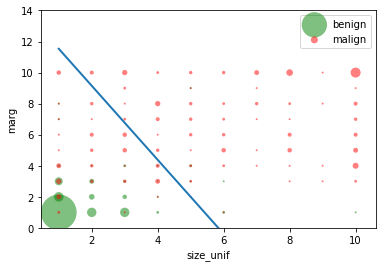

In [9]:
data = biopsy 
explanatory_variables = ["size_unif", "marg"] 
response_variables = "class"

w0=intercept
w1=slopes[0]
w2=slopes[1]

plot_histogram(data, explanatory_variables, response_variables)

xvalues = np.linspace(1, 6, 100)
yvalues = (0.5 - w0 - w1 * xvalues) / w2    
plt.plot(xvalues, yvalues, lw = 2);

So we can color the two regions red and green for malignant and benign

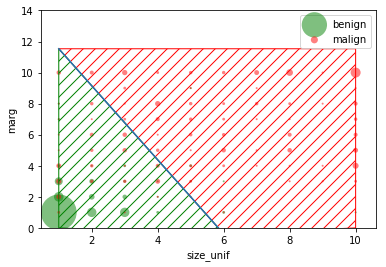

In [10]:
data = biopsy 
explanatory_variables = ["size_unif", "marg"] 
response_variables = "class"

w0=intercept
w1=slopes[0]
w2=slopes[1]

plot_histogram(data, explanatory_variables, response_variables)

xvalues = np.linspace(1, 6, 100)
yvalues = (0.5 - w0 - w1 * xvalues) / w2    
plt.plot(xvalues, yvalues)

add_patch(plt.gca(), [[1,0],[xvalues[-1],yvalues[-1]],[xvalues[0],yvalues[0]]])
add_patch(plt.gca(), [[xvalues[-1],yvalues[-1]],[10,0],[10,yvalues[0]],[xvalues[0],yvalues[0]]], "red");

We should compute the accuracy of the predictions.

In [11]:
# compute predictions
yhat = linear_model.predict(data[explanatory_variables])

# use predictions for classification
yhat_classification = np.where(0.5 <= yhat, 1, 0)

# calculate accuracy
accuracy = np.mean(yhat_classification == data[response_variables])

print(f"Accuracy on training data using two features = {accuracy:0.4f}")

Accuracy on training data using two features = 0.9224


We have used two of nine features. If we add he other seven features, then we might have more accurate predictions.

In [14]:
def convert_to_standard_units(array):
    return (array - array.mean()) / array.std()

Before we fit a model to data, we want the features to have the same scale. Here the values all lie between 0 and 10. However, Remember we convert to standard units to avoid any issues.

In [15]:
data = biopsy
explanatory_variables_extended = ['thick','size_unif','shape_unif','marg','cell_size','bare','chrom','normal','mit']
response_variables = "class"

linear_model = LinearRegression()
linear_model.fit(data[explanatory_variables_extended].apply(convert_to_standard_units),data[response_variables])

pd.DataFrame(data= {
    'Feature': explanatory_variables_extended, 
    'Slope': linear_model.coef_[0] })

,Feature,Slope
0,thick,0.089455
1,size_unif,0.089455
2,shape_unif,0.089455
3,marg,0.089455
4,cell_size,0.089455
5,bare,0.089455
6,chrom,0.089455
7,normal,0.089455
8,mit,0.089455


Again we can compute the accuracy.

In [16]:
# compute predictions
yhat = linear_model.predict(data[explanatory_variables_extended].apply(convert_to_standard_units))

# use predictions for classification
yhat_classification = np.where(0.5 <= yhat, 1, 0)

# calculate accuracy
accuracy = np.mean(yhat_classification == data[response_variables])

print(f"Accuracy on training data using two features = {accuracy:0.4f}")

Accuracy on training data using two features = 0.9605


##### Sigmoid Function

While we managed to get accurate classifications from linear regression, we should use logisitic regression. For logistic regression, we predict a probability: 

$$
    P(\text{Response Variable} = 1 \; | \; \text{Explanatory Variable})
$$

Note that we have a conditional probability. For fixed values of the explanatory variables, it indicates the chances of the reponse variable equaling 1. So we would use some combination of the nine explanatory variables to estimate the conditional probability that the response variable equals 1. Here we assume that the conditional probability takes the form

$$
    P(\text{Response Variable} = 1 \; | \; \text{Explanatory Variable}) = \sigma(\text{Weighted Sum}), 
$$
where 

$$
\text{Weighted Sum} = w_0 + w_1 \cdot \text{Explanatory Variable 1} + \cdots + w_m \cdot \text{Explanatory Variable m}  
$$

and 

$$
    \sigma(t) = \frac{1}{1+e^{-t}}
$$

To better understand the sigmoid function $\sigma$, suppose we have one explanatory variable with no intercept. So $$P(\text{Response Variable} = 1 \; | \; \text{Explanatory Variable}) = \sigma(w_1 \cdot \text{Explanatory Variable})$$ for some slope $w_1$.  We plot different values of $w_1$.

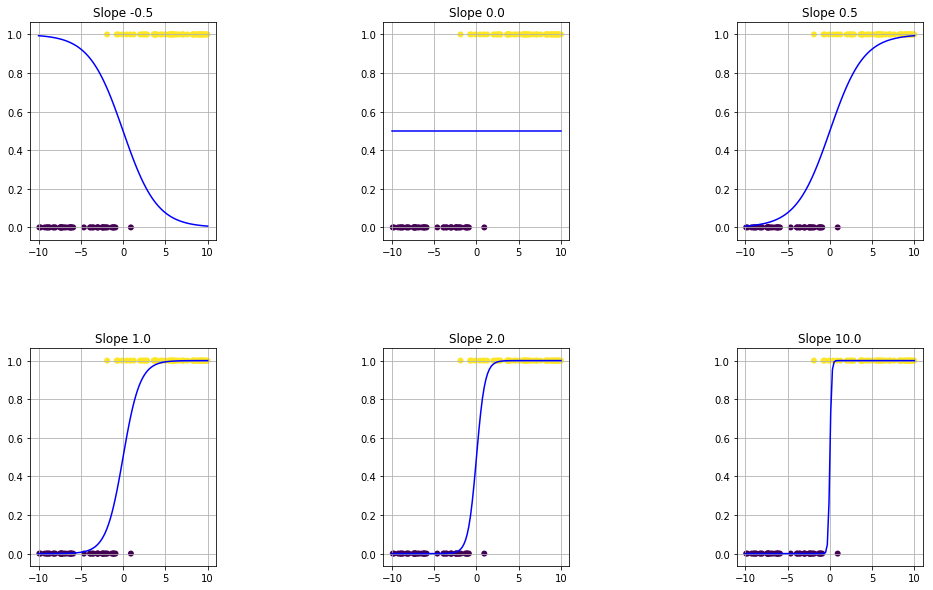

In [17]:
def sigmoid(t):
    return 1 / (1 + np.exp(-t))

plot_sigmoid()

So $\sigma(w_1 \cdot \text{Explanatory Variable})$ represents the probability that the response variable equals 1. Assuming that $w_1 > 0$, if 
$$\sigma(w_1 \cdot \text{Explanatory Variable}) > 0.5$$ 

then the response variable will more likely equal 1.  Similarly, if 
$$\sigma(w_1 \cdot \text{Explanatory Variable}) \leq 0.5$$ 

then the response variable will more likely equal 0. The value of the slope $w_1$ determines the rate of increase between 0 and 1.

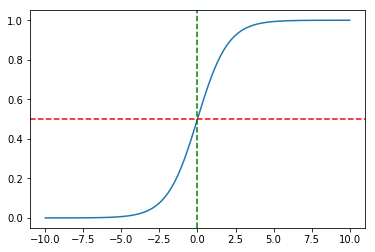

In [18]:
xvalues = np.linspace(-10,10,100)
yvalues = sigmoid(xvalues)
plt.plot(xvalues, yvalues)
plt.axvline(x = 0, color = "green", linestyle = "dashed")
plt.axhline(y = 0.5, color = "red", linestyle = "dashed");

##### Logistic Regression

We can try to fit a logistic regression model to the data. We will want to evaluate the accuracy out-so-sample on a testing set. So we should split into a training set and testing set.

In [19]:
biopsy_shuffled = biopsy.sample(frac = 1, replace= True, random_state=42)

number_records_training_set = int(0.8 * len(biopsy))

training_set = biopsy_shuffled.iloc[:number_records_training_set,:] 
testing_set = biopsy_shuffled.iloc[number_records_training_set:,:] 

print("Training Data Size: ", len(training_set))
print("Test Data Size: ", len(testing_set))

Training Data Size:  546
Test Data Size:  137


Remember that we sample with replacement to shuffle the rows. After we shuffle the rows, we can choose 80% for training set and 20% for testing set.

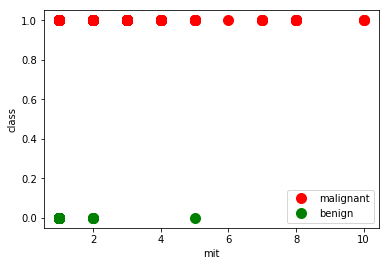

In [20]:
# Get records
malignant_records = training_set[training_set["class"] == 1] 
benign_records =  training_set[training_set["class"] == 0]

# Create the scatter plot
plt.xlabel('mit')
plt.ylabel('class')

plt.plot(malignant_records["mit"],malignant_records["class"],'r.', markersize = 20, label = "malignant")
plt.plot(benign_records["mit"],benign_records["class"],'g.', markersize = 20, label = "benign")

plt.legend();

Here we take `mit` for the explanatory variable and `class` for the response variable. Before we try logistic regression, we should try binned regression. 

In [22]:
bins = pd.cut(training_set["mit"], 5)
training_set_groups = training_set.groupby(bins).agg({"mit":np.median, "class":np.mean})
training_set_groups.rename(columns = {"mit":"Median Value of mit", "class":"Mean Value of class"}, inplace = True)
training_set_groups

,Median Value of mit,Mean Value of class
mit,,
"(0.991, 2.8]",1,0.289916
"(2.8, 4.6]",3,1.000000
"(4.6, 6.4]",5,0.900000
"(6.4, 8.2]",8,1.000000
"(8.2, 10.0]",10,1.000000


We group the data into five ranges of values for the `mit` feature. We use the median to summarize the values of `mit` and the mean to summarize the values of `class`. Note that the average of the values of `class` give the proportion of malignant records.

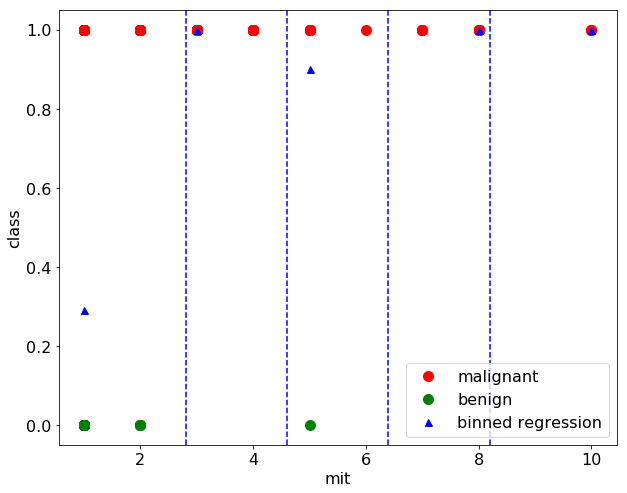

In [25]:
# Get records
malignant_records = training_set[training_set["class"] == 1] 
benign_records =  training_set[training_set["class"] == 0]

# Create the scatter plot
plt.xlabel('mit')
plt.ylabel('class')

# Plot the values
plt.plot(malignant_records["mit"],malignant_records["class"],'r.', markersize = 20, label = "malignant")
plt.plot(benign_records["mit"],benign_records["class"],'g.', markersize = 20, label = "benign")
plt.plot(training_set_groups["Median Value of mit"], training_set_groups["Mean Value of class"], 'b^', linewidth = 2, markersize = 7, label="binned regression")

# Indicate the bins
for bins in training_set_groups.index[:-1]:
    plt.axvline(x = bins.right, color = "blue", linestyle = "dashed")

plt.legend();

For binned regression, we plot the summary statistics for the five groups. With five points insted of 546 points, we can understand the trends and patterns in the data. 

In [27]:
def logistic_loss(y, y_hat):
    return -y * np.log(y_hat) - (1-y) * np.log(1-y_hat)

def average_logistic_loss(w):
    x = training_set["mit"]
    y_obs = training_set["class"]
    y_hat = sigmoid(w[0] + w[1] * x)
    return np.mean(logistic_loss(y_obs, y_hat))

While binned regression helps us to understand the data, we need logistic regression to guess `class` from `mit`. In particular, binned regression will not help us to make predictions on the testing set.

Remember that we use the logistic loss function to fit the model to the data. 

In [28]:
slopes = minimize(average_logistic_loss, x0 = [0,0]).x
print('Intercept =', slopes[0])
print('Slopes =', slopes[1])

Intercept = -3.447672164201143
Slopes = 2.3806735282440106


We use `minimize` in the `scipy.optimize` package to determine the parameters for the logistic regression model. Remember that `minimize` runs gradient descent for us. 

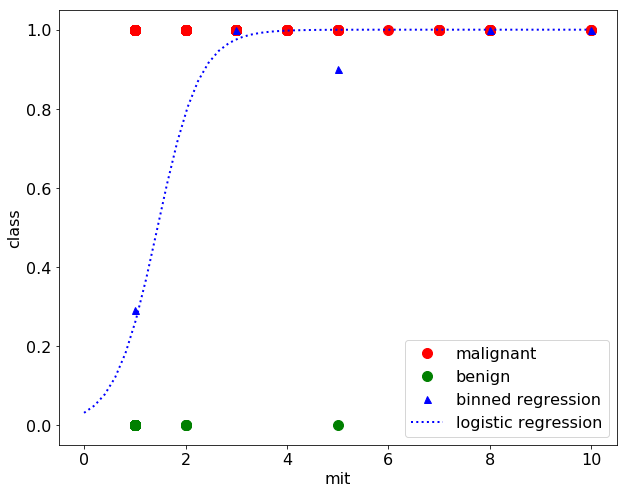

In [29]:
# Get records
malignant_records = training_set[training_set["class"] == 1] 
benign_records =  training_set[training_set["class"] == 0]

# Create the scatter plot
plt.xlabel('mit')
plt.ylabel('class')

plt.plot(malignant_records["mit"],malignant_records["class"],'r.', markersize = 20, label = "malignant")
plt.plot(benign_records["mit"],benign_records["class"],'g.', markersize = 20, label = "benign")

plt.plot(training_set_groups["Median Value of mit"], training_set_groups["Mean Value of class"], 'b^', linewidth = 2, markersize = 7, label="binned regression")

x = np.linspace(0,10,50)
plt.plot(x, sigmoid(slopes[0] + slopes[1] * x), 'b:', linewidth = 2, label="logistic regression")

plt.legend();

With the slope and intercept, we can plot the predicted probabilities of `class` conditional on `mit`. We manage to connect four of five points from binned regression.

In [30]:
# compute predictions
x = training_set["mit"]
yhat = sigmoid(slopes[0] + slopes[1] * x)

# use predictions for classification
yhat_classification = np.where(0.5 <= yhat, 1, 0)

# calculate accuracy
accuracy = np.mean(yhat_classification == training_set["class"])

print(f"Accuracy on training data using two features = {accuracy:0.4f}")

Accuracy on training data using two features = 0.7857


The accuracy on the training set gives us the in-sample error. However, we want to know the out-of-sample error.

In [32]:
# compute predictions
x = testing_set["mit"]
yhat = sigmoid(slopes[0] + slopes[1] * x)

# use predictions for classification
yhat_classification = np.where(0.5 <= yhat, 1, 0)

# calculate accuracy
accuracy = np.mean(yhat_classification == testing_set["class"])

print(f"Accuracy on training data using two features = {accuracy:0.4f}")

Accuracy on training data using two features = 0.7664


The accuracy of 76% seems reasonable for the testing set. However, we should compare to a benchmark. If we were to guess at random with 50% chance of malignant and 50% chance of benign then we expect the accuracy to be about 50%. Note that the dataset contains more records of benign than malignant.

In [33]:
number_malignant = len(testing_set[testing_set["class"] == 1])
number_benign = len(testing_set[testing_set["class"] == 0])

print(f"Number of malignant records {number_malignant}")
print(f"Number of benign records {number_benign}")

Number of malignant records 50
Number of benign records 87


So we should not guess at random with chance with 50% chance of malignant and 50% chance of benign. Instead we could guess with probabilities reflecting the number of malignant records and benign records

In [59]:
probability_malignant = 50 / (50 + 87)

yhat_classification = [np.random.binomial(1, probability_malignant) for trial in range(len(testing_set))]

accuracy = np.mean(yhat_classification == testing_set["class"])

print(f"Accuracy on training data using two features = {accuracy:0.4f}")

Accuracy on training data using two features = 0.5036


Alternatively we could alway guess benign.

In [60]:
# use predictions for classification
yhat_classification = np.zeros(len(testing_set))

# calculate accuracy
accuracy = np.mean(yhat_classification == testing_set["class"])

print(f"Accuracy on training data using two features = {accuracy:0.4f}")

Accuracy on training data using two features = 0.6350


Note that 63% does not differ much from the 76% of the model

##### Multiple Features

We might improve the accuracy of the predictions through additional features. Remember that the logisitic regression model takes the form

$$P(\text{Response Variable} = 1 \; | \; \text{Explanatory Variable}) = \sigma(w_0 + w_1 \cdot \text{Explanatory Variable 1} + \cdots + w_m \cdot \text{Explanatory Variable m} )$$

We can use scikit-learn to fit the model to the data.

In [61]:
data = training_set
explanatory_variables_extended = ['thick','size_unif','shape_unif','marg','cell_size','bare','chrom','normal','mit']
response_variables = "class"

logistic_model = LogisticRegression()
logistic_model.fit(data[explanatory_variables_extended].apply(convert_to_standard_units),data[response_variables])

pd.DataFrame(data= {
    'Feature': explanatory_variables_extended, 
    'Slope': logistic_model.coef_[0]})

,Feature,Slope
0,thick,0.884850
1,size_unif,0.071957
2,shape_unif,1.095548
3,marg,0.780344
4,cell_size,-0.141151
5,bare,1.084682
6,chrom,1.035673
7,normal,1.034414
8,mit,0.733239


We can compute the accuracy on the training set.

In [63]:
yhat = logistic_model.predict_proba(training_set[explanatory_variables_extended].apply(convert_to_standard_units))

yhat_classification = np.where(0.5 <= yhat[:,1], 1, 0)

accuracy = np.mean(yhat_classification == training_set["class"])

print(f"Accuracy on training data using two features = {accuracy:0.4f}")

Accuracy on training data using two features = 0.9707


We can compute the accuracy on the testing set.

In [64]:
yhat_classification = logistic_model.predict(testing_set[explanatory_variables_extended].apply(convert_to_standard_units))

accuracy = np.mean(yhat_classification == testing_set["class"])

print(f"Accuracy on training data using two features = {accuracy:0.4f}")

Accuracy on training data using two features = 0.9416


While we have good accuracy with logistic regression, we should explore other approaches to assessing the model.

#### Evaluating the Classifications

We have been comparing observations and predictions through accuracy. However we should try to understand the type of errors in the classification. We will unpack these error through other metrics. 

##### Confusion Matrix

We have two possible values for the response variable either 0 and 1. We have two possible values for the guesses either 0 or 1. So we have four possibilities. 

- True Positive : Observation = 1 and Prediction = 1
- False Positive : Observation = 0 and Prediction = 1
- True Negative : Observation = 0 and Prediction = 0
- False Negative : Observation = 1 and Prediction = 0

We can calculate these four possibilities

In [65]:
observed =  testing_set["class"]
predicted = yhat_classification 

tp = sum((observed == predicted) & (observed == 1))
tn = sum((observed == predicted) & (observed == 0))
fp = sum((observed != predicted) & (observed == 0))
fn = sum((observed != predicted) & (observed == 1))

We can plot these four possibilities in a confusion matrix.

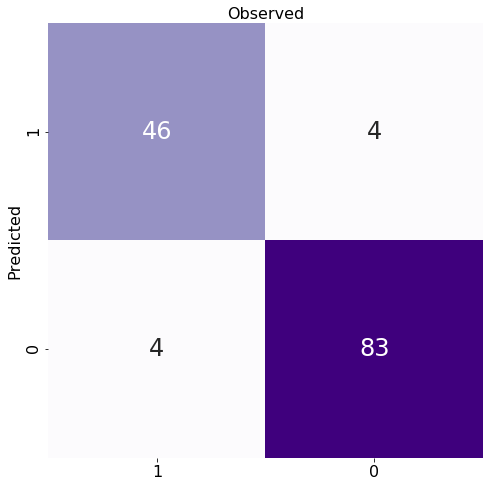

In [66]:
confusion_matrix = np.array([
    [tp, fp],
    [fp, tn],
])
    
plot_confusion(confusion_matrix)

We learn that we have 

- 46 True Positive's 
- 4 False Positive's 
- 83 True Negative's
- 4 False Negative's

on the testing set for the logistic regression model with nine features.

In [67]:
def accuracy(observed, predicted):
    return np.mean(observed == predicted)

accuracy(observed, predicted)

0.9416058394160584

In addition to the accuracy, we have precision and recall. 

In [68]:
def precision(observed, predicted):    
    tp = sum((observed == predicted) & (observed == 1))
    fp = sum((observed != predicted) & (observed == 0))
   
    return tp / (tp + fp)

precision(observed, predicted)

0.92

Precision measures the number of true postives amongst predictions of 1.

In [69]:
def recall(observed, predicted):
    tp = sum((observed == predicted) & (observed == 1))
    fn = sum((observed != predicted) & (observed == 1))

    return tp / (tp + fn)

recall(observed, predicted)

0.92

Remember that we took the threshold to be 0.5. If we adjust the threshold then we obtain different values for accuracy, precision and recall.

In [70]:
accuracies = []
precisions = []
recalls = []
thresholds = np.arange(0.1, 0.9, 0.1)

yhat = logistic_model.predict_proba(testing_set[explanatory_variables_extended].apply(convert_to_standard_units))

for threshold in thresholds:
    predicted = np.where(threshold <= yhat[:,1], 1, 0)

    acc = accuracy(observed, predicted)
    pre = precision(observed, predicted)
    rec = recall(observed, predicted)

    accuracies.append(acc)
    precisions.append(pre)
    recalls.append(rec)
    
    print("threshold p >= {}: accuracy {}, precision {}, recall {}".format(np.round(threshold,2), 
                                                                           np.round(acc, 2),
                                                                           np.round(pre, 2),
                                                                           np.round(rec, 2)))

threshold p >= 0.1: accuracy 0.93, precision 0.87, recall 0.96
threshold p >= 0.2: accuracy 0.95, precision 0.91, recall 0.96
threshold p >= 0.3: accuracy 0.95, precision 0.91, recall 0.96
threshold p >= 0.4: accuracy 0.95, precision 0.92, recall 0.94
threshold p >= 0.5: accuracy 0.94, precision 0.92, recall 0.92
threshold p >= 0.6: accuracy 0.94, precision 0.94, recall 0.9
threshold p >= 0.7: accuracy 0.93, precision 0.93, recall 0.86
threshold p >= 0.8: accuracy 0.93, precision 0.96, recall 0.86


We can plot the values in a precision-recall curve.

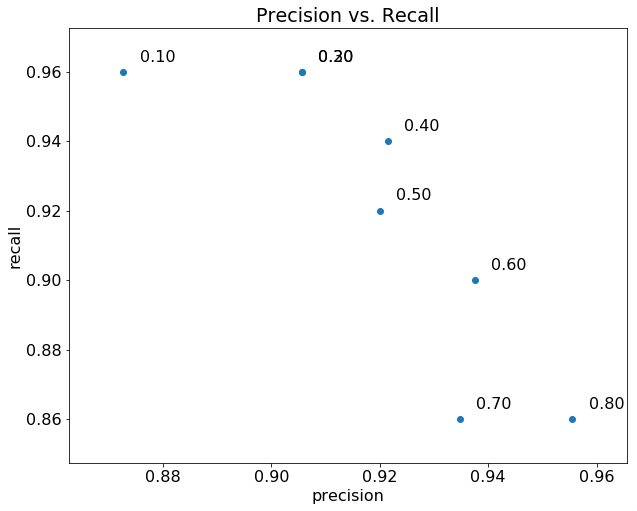

In [71]:
plt.scatter(precisions, recalls)

for thresh, prec, rec in zip(thresholds, precisions, recalls):
    plt.text(prec + 0.003, rec + 0.003, f"{thresh:0.2f}")

plt.xlabel('precision')
plt.ylabel('recall')
plt.title('Precision vs. Recall');

Note that if we increase the threshold then the precision increases. However the recall decreases with larger thresholds. So we have to balance the precision and recall.